<a href="https://colab.research.google.com/github/trinaxavier2001/SkinLesionClassification/blob/main/Swin_Model_using_FocalLoss_AdamW_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade git+https://github.com/rwightman/pytorch-image-models.git


  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-ez5kheqt
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-ez5kheqt
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit c8c4f256b8c279575ed87012f38620a4cd25df57
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install torch-optimizer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.8 MB/s eta 0:00:00


In [10]:
import os, copy, numpy as np, pandas as pd, matplotlib.pyplot as plt
from PIL import Image
from glob import glob

import torch, timm, wandb
import torch.nn.functional as F
from torch import nn
from torch.optim import AdamW, Optimizer
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from torchvision import transforms

In [11]:
DEVICE               = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DF_PATH              = '/content/drive/MyDrive/Skin_Disease_Model/metadata_with_image_descriptions.csv'
IMG_DIRS             = ['/content/drive/MyDrive/Skin_Disease_Model/HAM10000_images_part_1',
                        '/content/drive/MyDrive/Skin_Disease_Model/HAM10000_images_part_2']
BATCH_SIZE           = 16
IMG_SIZE             = 224
EPOCHS               = 80
HEAD_WARMUP_EPOCHS   = 8      # head‐only for first 8 epochs
AUG_WARMUP_EPOCHS    = 10     # light aug until epoch 10
BLOCK3_UNFREEZE_EPOCH= 10
BLOCK3_UNFREEZE_F1   = 0.40
MAX_LR               = 3e-4
PCT_START            = 0.1
DIV_FACTOR           = 25
FINAL_DIV_FACTOR     = 1e4
PATIENCE             = 7
LAST_CKPT_PATH = '/content/drive/MyDrive/swin_skin_model/swin_best.pth'
BEST_CKPT_PATH = '/content/drive/MyDrive/swin_skin_model/swin_resume.pth'
os.makedirs(os.path.dirname(LAST_CKPT_PATH), exist_ok=True)

In [5]:
df = pd.read_csv(DF_PATH)
def resolve_path(i):
    for d in IMG_DIRS:
        p = os.path.join(d, f"{i}.jpg")
        if os.path.exists(p): return p
    return None
df['file_path'] = df.image_id.map(resolve_path)
df = df.dropna(subset=['file_path']).reset_index(drop=True)
df['label'] = pd.Categorical(df.dx).codes
label_map  = dict(enumerate(pd.Categorical(df.dx).categories))
num_classes = len(label_map)

train_df, tmp = train_test_split(df, test_size=0.3,
                                 stratify=df.label, random_state=42)
val_df, _     = train_test_split(tmp, test_size=0.5,
                                 stratify=tmp.label, random_state=42)

# sampler & class weights
train_counts  = train_df.label.value_counts().sort_index().values
class_weights = torch.tensor((1.0/train_counts), dtype=torch.float32, device=DEVICE)
sample_weights= class_weights[train_df.label.values]
train_sampler = WeightedRandomSampler(sample_weights,
                                      len(sample_weights),
                                      replacement=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,gemini_image_description,file_path,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,The image shows disease benign keratosis-like ...,/content/drive/MyDrive/Skin_Disease_Model/HAM1...,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,The image shows disease benign keratosis-like ...,/content/drive/MyDrive/Skin_Disease_Model/HAM1...,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,The image shows disease benign keratosis-like ...,/content/drive/MyDrive/Skin_Disease_Model/HAM1...,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,The image shows disease benign keratosis-like ...,/content/drive/MyDrive/Skin_Disease_Model/HAM1...,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,The image shows disease benign keratosis-like ...,/content/drive/MyDrive/Skin_Disease_Model/HAM1...,2


In [7]:
# Assuming `df` is your full dataframe with a 'dx' column for diagnosis:

# 1. Filter rows where the diagnosis equals "melanoma"
mel_df = df[df['dx'].str.lower() == 'mel']

# 2. Extract the image IDs
melanoma_ids = mel_df['image_id'].tolist()

# 3. (Optional) Print the first 10 to verify
print("First 10 melanoma image_ids:", melanoma_ids[:10])

# 4. You can also check how many there are:
print(f"Total melanoma samples: {len(melanoma_ids)}")


First 10 melanoma image_ids: ['ISIC_0025964', 'ISIC_0030623', 'ISIC_0027190', 'ISIC_0031023', 'ISIC_0028086', 'ISIC_0031177', 'ISIC_0026993', 'ISIC_0026120', 'ISIC_0028412', 'ISIC_0030417']
Total melanoma samples: 1113


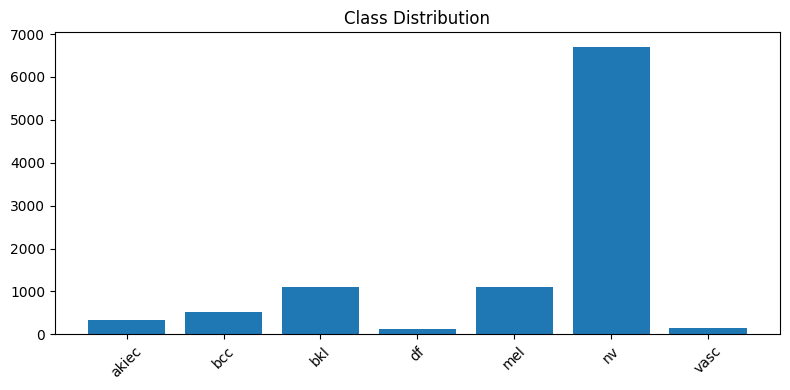

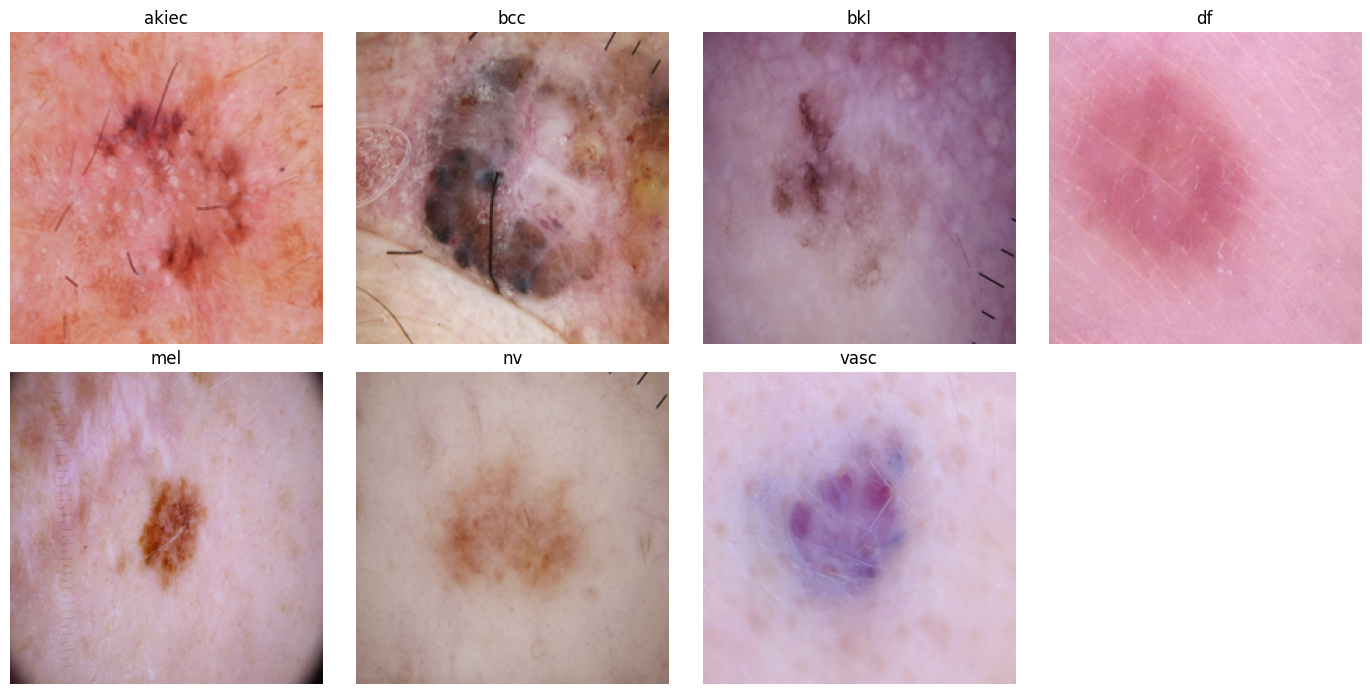

In [4]:
# ======================= DATA EXPLORATION =======================
class_counts = df['label'].value_counts().sort_index()
plt.figure(figsize=(8,4))
plt.bar([label_map[i] for i in class_counts.index], class_counts.values)
plt.xticks(rotation=45)
plt.title('Class Distribution')
plt.tight_layout(); plt.show()

plt.figure(figsize=(14,7))
for i,label in enumerate(class_counts.index[:7]):
    sample = df[df['label']==label].sample(1).iloc[0]
    img = Image.open(sample['file_path']).convert('RGB').resize((IMG_SIZE,IMG_SIZE))
    plt.subplot(2,4,i+1); plt.imshow(img)
    plt.title(label_map[label]); plt.axis('off')
plt.tight_layout(); plt.show()

In [5]:
# ─── 2) TRANSFORMS ──────────────────────────────────────────────────────────
light_tfm = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])
heavy_tfm = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.3,0.3,0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
    transforms.RandomErasing()
])

class LesionDS(Dataset):
    def __init__(self, df, tfm):
        self.df, self.tfm = df, tfm
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = Image.open(r.file_path).convert('RGB')
        return self.tfm(img), torch.tensor(r.label, dtype=torch.long)

train_ds = LesionDS(train_df, light_tfm)
val_ds   = LesionDS(val_df,   light_tfm)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=2, pin_memory=True)


In [ ]:
# ───────────────────── FOCAL LOSS ──────────────────────────────────────────
class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=1.0, smooth=0.0):
        super().__init__()
        self.alpha, self.gamma, self.smooth = alpha, gamma, smooth
    def forward(self, logits, targets):
        targets = targets.long()
        C = logits.size(1)
        with torch.no_grad():
            true_dist = torch.full_like(logits, self.smooth/(C-1))
            true_dist.scatter_(1,
                  targets.unsqueeze(1), 1-self.smooth)
        logp = F.log_softmax(logits, dim=1)
        ce   = -(true_dist * logp).sum(1)
        pt   = torch.exp(-ce)
        return ((1-pt)**self.gamma * ce).mean()


# EMA helper
class EMA:
    def __init__(self, model, decay=0.995):
        self.ema   = copy.deepcopy(model).eval()
        self.decay = decay
        for p in self.ema.parameters(): p.requires_grad=False
    @torch.no_grad()
    def update(self, model):
        for e, p in zip(self.ema.parameters(), model.parameters()):
            e.mul_(self.decay).add_(p.data*(1-self.decay))

In [ ]:
#  SAM wrapper
class SAM(Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        defaults = dict(rho=rho, **kwargs)
        super().__init__(params, defaults)
        self.base_optimizer = base_optimizer(self.param_groups,
                                             **kwargs)
        self.rho = rho
    @torch.no_grad()
    def first_step(self, zero_grad=True):
        grads = [p.grad.norm(2).to(p.device)
                 for g in self.param_groups
                 for p in g['params']
                 if p.grad is not None]
        norm = torch.norm(torch.stack(grads), p=2)
        scale = self.rho/(norm+1e-12)
        for g in self.param_groups:
            for p in g['params']:
                if p.grad is None: continue
                e = p.grad * scale
                p.add_(e)
                self.state[p]['e_w'] = e
        if zero_grad: self.zero_grad()
    @torch.no_grad()
    def second_step(self, zero_grad=True):
        for g in self.param_groups:
            for p in g['params']:
                e = self.state[p].get('e_w')
                if e is None: continue
                p.sub_(e)
        self.base_optimizer.step()
        if zero_grad: self.zero_grad()
    def step(self, *args, **kwargs):
        raise RuntimeError("Use first_step/second_step")
    def zero_grad(self):
        self.base_optimizer.zero_grad()

In [ ]:
model = timm.create_model('swin_base_patch4_window7_224',
                          pretrained=True,
                          num_classes=num_classes).to(DEVICE)

# freeze all except head
for n,p in model.named_parameters():
    if 'head' not in n: p.requires_grad=False

criterion = FocalLoss(alpha=class_weights,
                      gamma=2.0, smooth=0.1)

# AdamW on head-only
adam_opt = AdamW(filter(lambda p: p.requires_grad,
                        model.parameters()),
                 lr=MAX_LR/DIV_FACTOR,
                 weight_decay=1e-2)

scheduler = OneCycleLR(adam_opt,
    max_lr=MAX_LR,
    total_steps=EPOCHS*len(train_loader),
    pct_start=PCT_START,
    anneal_strategy='cos',
    div_factor=DIV_FACTOR,
    final_div_factor=FINAL_DIV_FACTOR
)

ema = EMA(model, decay=0.995)
# SAM placeholder (initialized after unfreeze)
sam_opt = None
using_sam = False

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
# ▶ Resume checkpoint
start_epoch, best_f1, block3_unfrozen = 0, 0.0, False
if os.path.exists(LAST_CKPT_PATH):
    ckpt = torch.load(LAST_CKPT_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt['model'])
    adam_opt.load_state_dict(ckpt['opt'])
    scheduler.load_state_dict(ckpt['sched'])
    ema.ema.load_state_dict(ckpt['ema'])
    start_epoch     = ckpt['epoch'] + 1
    best_f1         = ckpt['best_f1']
    block3_unfrozen = ckpt.get('block3_unfrozen', False)
    using_sam       = ckpt.get('using_sam', False)
    if using_sam:
        # wrap SAM around current trainable params
        sam_opt = SAM(
          filter(lambda p: p.requires_grad, model.parameters()),
          base_optimizer=AdamW,
          rho=0.05,
          lr=MAX_LR, weight_decay=1e-2
        )
    print(f"→ Resuming epoch {start_epoch}, best_f1={best_f1:.4f}")
else:
    print("→ No checkpoint, starting fresh")


#  W&B init
wandb.login()
wandb.init(project="swin-lesion-capstone",
           name="hybrid-adamw-sam", resume="allow")
wandb.watch(model, log="all", log_freq=200)

# Early stopping counter
early_stop_counter = 0

# ▶ Training loop
for epoch in range(start_epoch, EPOCHS):
    # 1) pick aug
    train_ds.tfm = light_tfm if epoch < AUG_WARMUP_EPOCHS else heavy_tfm

    # 2) adjust gamma & smooth
    if epoch < AUG_WARMUP_EPOCHS:
        criterion.gamma, criterion.smooth = 1.0, 0.0
    else:
        criterion.gamma, criterion.smooth = 1.5, 0.1

    model.train()
    tr_loss, all_p, all_t = 0.0, [], []

    # decide which optimizer to use
    opt = sam_opt if using_sam else adam_opt

    for bi, (xb,yb) in enumerate(train_loader, 1):
        xb,yb = xb.to(DEVICE), yb.to(DEVICE)

        if using_sam:
            # SAM two-step
            def closure():
                opt.zero_grad()
                logits = model(xb)
                loss   = criterion(logits, yb)
                loss.backward()
                return loss, logits

            loss, logits = closure()
            opt.first_step(zero_grad=True)
            _, logits   = closure()
            opt.second_step(zero_grad=True)
        else:
            # plain AdamW
            adam_opt.zero_grad()
            logits = model(xb)
            loss   = criterion(logits, yb)
            loss.backward()
            adam_opt.step()
            scheduler.step()

        ema.update(model)
        tr_loss += loss.item()
        preds = logits.argmax(1).cpu().tolist()
        all_p += preds; all_t += yb.cpu().tolist()

        # print every 100 batches
        if bi % 100 == 0:
            lr = (sam_opt or adam_opt).param_groups[0]['lr']
            print(f"Epoch {epoch+1}/{EPOCHS}  Batch {bi}/{len(train_loader)}  "
                  f"Loss {loss.item():.4f}  LR {lr:.6f}")

    train_loss = tr_loss/len(train_loader)
    train_acc  = (np.array(all_p)==np.array(all_t)).mean()
    train_f1   = f1_score(all_t, all_p, average='macro')

    # 3) dynamic unfreeze block3
    if (not block3_unfrozen
        and (epoch+1)>=BLOCK3_UNFREEZE_EPOCH
        and train_f1>=BLOCK3_UNFREEZE_F1):
        for n,p in model.named_parameters():
            if 'layers.3' in n:
                p.requires_grad = True
        block3_unfrozen = True
        print(f" Unfroze block3 at epoch {epoch+1}")

        # now switch on SAM
        sam_opt = SAM(
          filter(lambda p: p.requires_grad, model.parameters()),
          base_optimizer=AdamW,
          rho=0.05,
          lr=MAX_LR, weight_decay=1e-2
        )
        using_sam = True
        print(" Switched to SAM for remaining training")

    # 4) validation
    ema_model = ema.ema.eval()
    vl, vp, vt = 0.0, [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb,yb    = xb.to(DEVICE), yb.to(DEVICE)
            logits   = ema_model(xb)
            vl      += F.cross_entropy(logits, yb).item()
            preds    = logits.argmax(1).cpu().tolist()
            vp      += preds; vt += yb.cpu().tolist()

    val_loss = vl/len(val_loader)
    val_acc  = accuracy_score(vt, vp)
    val_f1   = f1_score(vt, vp, average='macro')

    # 5) W&B & print
    wandb.log(dict(
      epoch=epoch,
      train_loss=train_loss, train_acc=train_acc, train_f1=train_f1,
      val_loss=val_loss,     val_acc=val_acc,     val_f1=val_f1,
      lr=(sam_opt or adam_opt).param_groups[0]['lr'],
      using_sam=using_sam
    ))
    print(f"Epoch {epoch+1}/{EPOCHS}  "
          f"Train Loss {train_loss:.4f} Train Accuracy {train_acc:.4f} Train F1 {train_f1:.4f}  "
          f"Val Loss {val_loss:.4f} Val Accuracy {val_acc:.4f} Val F1 {val_f1:.4f}")

    # 6) checkpoint
    torch.save({
      'epoch':            epoch,
      'model':            model.state_dict(),
      'opt':              adam_opt.state_dict(),
      'sched':            scheduler.state_dict(),
      'ema':              ema.ema.state_dict(),
      'best_f1':          best_f1,
      'block3_unfrozen':  block3_unfrozen,
      'using_sam':        using_sam
    }, LAST_CKPT_PATH)

    # best
    # best checkpoint logic with early stopping
    if val_f1 > best_f1:
       best_f1 = val_f1
       early_stop_counter = 0  # reset counter
       torch.save({'epoch': epoch, 'model': model.state_dict(),
                 'best_f1': best_f1}, BEST_CKPT_PATH)
       print(f"  New best F1={best_f1:.4f}")
    else:
         early_stop_counter += 1
         print(f" No improvement in F1 for {early_stop_counter} epoch(s)")

         if early_stop_counter >= PATIENCE:
           print(f" Early stopping triggered after {PATIENCE} epochs without F1 improvement.")
           break


print(" Training complete.")

→ Resuming epoch 24, best_f1=0.7815


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: trinaxavier21 (trinaxavier21-university-of-massachusetts) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 25/80  Batch 100/439  Loss 0.2703  LR 0.000300
Epoch 25/80  Batch 200/439  Loss 0.2707  LR 0.000300
Epoch 25/80  Batch 300/439  Loss 0.3730  LR 0.000300
Epoch 25/80  Batch 400/439  Loss 0.2219  LR 0.000300
Epoch 25/80  Train Loss 0.3273 Train Accuracy 0.8802 Train F1 0.8806  Val Loss 0.5226 Val Accuracy 0.8222 Val F1 0.7778
 No improvement in F1 for 1 epoch(s)
Epoch 26/80  Batch 100/439  Loss 0.2395  LR 0.000300
Epoch 26/80  Batch 200/439  Loss 0.3449  LR 0.000300
Epoch 26/80  Batch 300/439  Loss 0.3917  LR 0.000300
Epoch 26/80  Batch 400/439  Loss 0.1928  LR 0.000300
Epoch 26/80  Train Loss 0.3234 Train Accuracy 0.8833 Train F1 0.8832  Val Loss 0.5114 Val Accuracy 0.8182 Val F1 0.7744
 No improvement in F1 for 2 epoch(s)
Epoch 27/80  Batch 100/439  Loss 0.2091  LR 0.000300
Epoch 27/80  Batch 200/439  Loss 0.2318  LR 0.000300
Epoch 27/80  Batch 300/439  Loss 0.5523  LR 0.000300
Epoch 27/80  Batch 400/439  Loss 0.3854  LR 0.000300
Epoch 27/80  Train Loss 0.3178 Train Accuracy 0.88

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
BEST_CKPT_PATH = "/content/drive/MyDrive/swin_skin_model/swin_best.pth"

# 1) Recreate a test split from the leftover tmp
_, test_df = train_test_split(
    tmp,                     # the same tmp you used for val
    test_size=0.5,
    stratify=tmp.label,
    random_state=42
)

# 2) Build your test DataLoader
test_ds = LesionDS(test_df, light_tfm)       # light_tfm or whatever final transform you want
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# 3) Load your best‐model checkpoint
checkpoint = torch.load(BEST_CKPT_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['model'])
model.to(DEVICE).eval()

# 4) Run inference & collect preds
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        preds  = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# 5) Compute metrics
acc = accuracy_score(all_labels, all_preds)
f1  = f1_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy:  {acc*100:.2f}%")
print(f"Test Macro F1:  {f1:.4f}\n")
print("Per‐class performance:")
print(classification_report(
    all_labels,
    all_preds,
    target_names=[label_map[i] for i in range(num_classes)],
    digits=4
))


Test Accuracy:  81.84%
Test Macro F1:  0.7715

Per‐class performance:
              precision    recall  f1-score   support

       akiec     0.6316    0.7347    0.6792        49
         bcc     0.7753    0.8961    0.8313        77
         bkl     0.6719    0.7818    0.7227       165
          df     0.8235    0.8235    0.8235        17
         mel     0.4881    0.7365    0.5871       167
          nv     0.9654    0.8320    0.8938      1006
        vasc     0.7586    1.0000    0.8627        22

    accuracy                         0.8184      1503
   macro avg     0.7306    0.8292    0.7715      1503
weighted avg     0.8549    0.8184    0.8295      1503



In [12]:
import random
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

# ─── CONFIG ────────────────────────────────────────────────────────────────────
DEVICE        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BEST_CKPT     = "/content/drive/MyDrive/swin_skin_model/swin_best.pth"
LABEL_MAP     = label_map  # {0:'akiec', 1:'bcc', …}
IMG_SIZE      = 224
N_SAMPLES     = 6         # how many images to display

# ─── TRANSFORM ─────────────────────────────────────────────────────────────────
test_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

# ─── LOAD MODEL ────────────────────────────────────────────────────────────────
checkpoint = torch.load(BEST_CKPT, map_location=DEVICE)
model.load_state_dict(checkpoint['model'])
model.to(DEVICE).eval()

# ─── SAMPLE IMAGES ─────────────────────────────────────────────────────────────
# pick N_SAMPLES random rows from test_df
samples = test_df.sample(n=N_SAMPLES, random_state=42).reset_index(drop=True)

# ─── RUN INFERENCE & PLOT ──────────────────────────────────────────────────────
fig, axes = plt.subplots(1, N_SAMPLES, figsize=(3*N_SAMPLES, 3))
for ax, (_, row) in zip(axes, samples.iterrows()):
    # load & show the raw image
    img = Image.open(row.file_path).convert('RGB')
    ax.imshow(img)
    ax.axis('off')

    # preprocess & predict
    xb = test_tfm(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(xb)
        pred_idx = logits.argmax(dim=1).item()

    # get labels
    true_lbl = LABEL_MAP[row.label]
    pred_lbl = LABEL_MAP[pred_idx]

    # title with GT vs. Pred
    ax.set_title(f"GT: {true_lbl}\nPred: {pred_lbl}", fontsize=10)

plt.tight_layout()
plt.show()


NameError: name 'label_map' is not defined

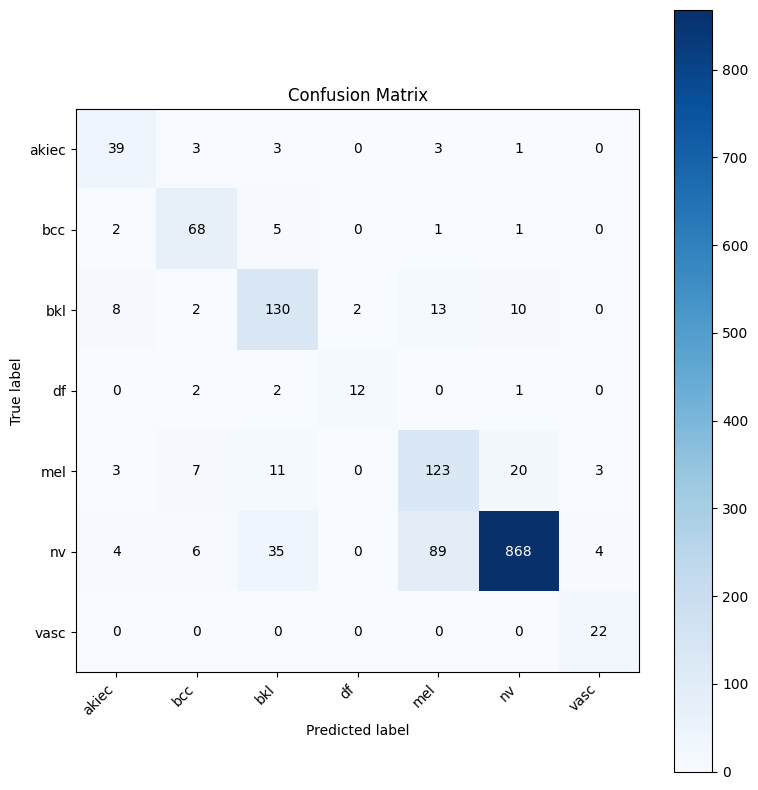

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1) Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# 2) Plot
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# 3) Ticks and labels
classes = [label_map[i] for i in range(len(label_map))]
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticklabels(classes)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')

# 4) Annotate counts
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [18]:
import torch
import timm
import pandas as pd
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

# 1) Re-define the exact model architecture
NUM_CLASSES = 7
MODEL_NAME  = 'swin_base_patch4_window7_224'
DEVICE      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 3) Load your best‐model checkpoint
checkpoint = torch.load(LAST_CKPT_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['model'])
model.to(DEVICE).eval()

# 2) Build your test DataLoader (using the same transforms & dataset you used in training)
IMG_SIZE = 224
test_tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

class LesionDS(torch.utils.data.Dataset):
    def __init__(self, df, tfm):
        self.df  = df.reset_index(drop=True)
        self.tfm = tfm
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row.file_path).convert('RGB')
        return self.tfm(img), row.label

test_ds     = LesionDS(test_df, test_tfm)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# 3) Run inference to collect true labels and predicted probabilities
all_labels = []
all_probs  = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        probs  = torch.softmax(logits, dim=1).cpu()
        all_probs .extend(probs.numpy())
        all_labels.extend(yb.numpy())

all_labels = np.array(all_labels)      # shape: (N,)
all_probs  = np.array(all_probs)       # shape: (N, NUM_CLASSES)

# 4) Compute overall (macro) ROC-AUC and per-class ROC-AUC
#    Note: you need one-hot targets for multi_class='ovr'
from sklearn.preprocessing import label_binarize

y_onehot = label_binarize(all_labels, classes=list(range(NUM_CLASSES)))

# overall macro averaged AUC
macro_auc = roc_auc_score(y_onehot, all_probs, average='macro', multi_class='ovr')
print(f"Overall macro ROC-AUC: {macro_auc:.4f}")

# per-class AUC
per_class_auc = roc_auc_score(y_onehot, all_probs, average=None, multi_class='ovr')
for i, auc in enumerate(per_class_auc):
    print(f"Class {i} ({label_map[i]}) ROC-AUC: {auc:.4f}")


Overall macro ROC-AUC: 0.9680
Class 0 (akiec) ROC-AUC: 0.9823
Class 1 (bcc) ROC-AUC: 0.9935
Class 2 (bkl) ROC-AUC: 0.9620
Class 3 (df) ROC-AUC: 0.9734
Class 4 (mel) ROC-AUC: 0.8991
Class 5 (nv) ROC-AUC: 0.9662
Class 6 (vasc) ROC-AUC: 0.9996
